1 Problem Statement

1.1 The ”Moving Circle” Dataset
You will generate a synthetic 2D dataset where the decision boundary is a circle. The underlying
”concept” (a circular region) remains constant, but the specific location of the circle shifts for
every task.

• Input Space: x ∈ R2 where x1,x2 ∈ [−5,5].

• Task Distribution p(T ): For each task Ti, generate a circle with a fixed radius r = 2.0
and a random center (cx,cy) sampled uniformly from [−3,3].

• Labels:
1.2 The Goal
y = 1 if
(x1 −cx)2 +(x2 −cy)2 < r
0 otherwise
Train a neural network fθ that can learn the decision boundary of a new, unseen circle using
only K=10 labeled examples (Support Set) and just 1 gradient update.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class MovingCircleTask:
    def __init__(self, radius=2.0):
        self.radius = radius
        # Random center (cx, cy) sampled uniformly from [-3, 3]
        self.cx = np.random.uniform(-3, 3)
        self.cy = np.random.uniform(-3, 3)

    def sample_data(self, k=10):
        # Input space: x1, x2 in [-5, 5]
        x = np.random.uniform(-5, 5, size=(k, 2))

        # Label: 1 if inside the circle, 0 otherwise
        distances = (x[:, 0] - self.cx)**2 + (x[:, 1] - self.cy)**2
        y = (distances < self.radius**2).astype(np.float32).reshape(-1, 1)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [18]:
class CircleMAML(nn.Module):
    def __init__(self):
        super(CircleMAML, self).__init__()
        # A simple MLP for 2D classification
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)

        # Functional forward pass using dict-based parameters
        x = nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return torch.sigmoid(x)

In [19]:
def train_circle_maml(model, epochs=5000, tasks_per_batch=10, k_shot=10, alpha=0.01, beta=0.001):
    optimizer = optim.Adam(model.parameters(), lr=beta)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        for _ in range(tasks_per_batch):
            task = MovingCircleTask()
            x_support, y_support = task.sample_data(k_shot)
            x_query, y_query = task.sample_data(k_shot)

            # --- Inner Loop (Adaptation) ---
            current_params = dict(model.named_parameters())
            y_pred_support = model(x_support, params=current_params)
            loss_inner = loss_fn(y_pred_support, y_support)

            # Gradients with respect to initial weights
            grads = torch.autograd.grad(loss_inner, current_params.values(), create_graph=True)

            # Compute one-step adapted parameters (theta')
            fast_weights = {}
            for (name, param), grad in zip(current_params.items(), grads):
                fast_weights[name] = param - alpha * grad

            # --- Outer Loop (Meta-Update) ---
            y_pred_query = model(x_query, params=fast_weights)
            loss_outer = loss_fn(y_pred_query, y_query)
            meta_loss += loss_outer

        # Update initial model parameters
        meta_loss /= tasks_per_batch
        meta_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Meta Loss = {meta_loss.item():.4f}")

    return model

Epoch 0: Meta Loss = 0.6840
Epoch 500: Meta Loss = 0.3033
Epoch 1000: Meta Loss = 0.2641
Epoch 1500: Meta Loss = 0.3213
Epoch 2000: Meta Loss = 0.3175
Epoch 2500: Meta Loss = 0.3006
Epoch 3000: Meta Loss = 0.2655
Epoch 3500: Meta Loss = 0.2091
Epoch 4000: Meta Loss = 0.2357
Epoch 4500: Meta Loss = 0.2778


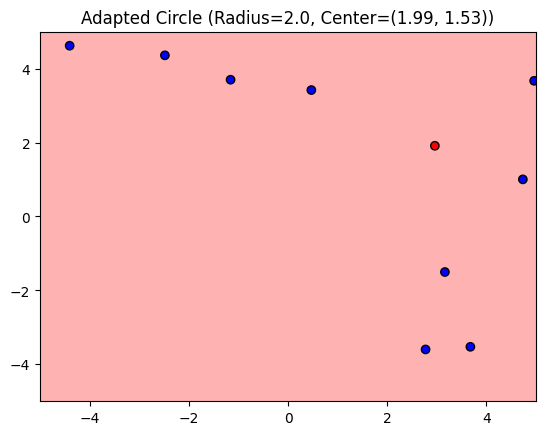

In [20]:
def visualize_adaptation(model, k_shot=10, alpha=0.01):
    test_task = MovingCircleTask()
    x_support, y_support = test_task.sample_data(k_shot)

    # 1-step adaptation
    current_params = dict(model.named_parameters())
    y_pred_support = model(x_support, params=current_params)
    loss = nn.BCELoss()(y_pred_support, y_support)
    grads = torch.autograd.grad(loss, current_params.values())

    fast_weights = {name: p - alpha * g for (name, p), g in zip(current_params.items(), grads)}

    # Generate grid for visualization
    grid_x, grid_y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_points = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)

    with torch.no_grad():
        preds = model(grid_points, params=fast_weights).reshape(100, 100).numpy()

    plt.contourf(grid_x, grid_y, preds, levels=[0, 0.5, 1], alpha=0.3, colors=['red', 'blue'])
    plt.scatter(x_support[:, 0], x_support[:, 1], c=y_support.flatten(), cmap='bwr', edgecolors='k')
    plt.title(f"Adapted Circle (Radius=2.0, Center=({test_task.cx:.2f}, {test_task.cy:.2f}))")
    plt.show()

# Run the training
maml_model = train_circle_maml(CircleMAML())
visualize_adaptation(maml_model)

2 Methodology

2.1 Part 1: MAML Implementation

Implement the MAML algorithm as described in Finn et al. (2017).

• Model Architecture: Of your Choice.

• Meta-Training:– Outer Loop: 2000 epochs.– Inner Loop: 1 gradient descent step– Meta-Update: As discussed

2.2 Part 2: Baseline Comparison (Standard Learning)

Train a baseline model to represent a non-meta-learning approach.

• Joint Training: Train a single network fϕ on data sampled from thousands of random
tasks simultaneously (mixing all circles together). Train for 2000 epochs.

• Fine-Tuning: At test time, take this pre-trained model and fine-tune it on the test task’s
Support Set using standard Gradient Descent

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- 1.1 Model Architecture ---
class CircleModel(nn.Module):
    def __init__(self):
        super(CircleModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)

        # Manual functional pass for MAML inner loop updates
        x = nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return torch.sigmoid(x)

# --- 1.2 Meta-Training (MAML) ---
def train_maml(model, epochs=2000, alpha=0.01, beta=0.001):
    optimizer = optim.Adam(model.parameters(), lr=beta)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        # Sample a batch of tasks
        for _ in range(5):
            task = MovingCircleTask() # Defined in previous step
            x_s, y_s = task.sample_data(k=10) # Support Set
            x_q, y_q = task.sample_data(k=10) # Query Set

            # Inner Loop: 1 gradient descent step
            current_params = dict(model.named_parameters())
            y_pred_s = model(x_s, params=current_params)
            loss_s = loss_fn(y_pred_s, y_s)

            # Use create_graph=True for the meta-update gradient
            grads = torch.autograd.grad(loss_s, current_params.values(), create_graph=True)
            fast_weights = {name: p - alpha * g for (name, p), g in zip(current_params.items(), grads)}

            # Meta-Update: Evaluate on Query Set
            y_pred_q = model(x_q, params=fast_weights)
            meta_loss += loss_fn(y_pred_q, y_q)

        meta_loss /= 5
        meta_loss.backward()
        optimizer.step()

In [22]:
def train_baseline(model, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Mix data from 5 different random tasks per batch
        x_mixed, y_mixed = [], []
        for _ in range(5):
            task = MovingCircleTask()
            x, y = task.sample_data(k=20)
            x_mixed.append(x)
            y_mixed.append(y)

        x_train = torch.cat(x_mixed)
        y_train = torch.cat(y_mixed)

        preds = model(x_train)
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

In [23]:
def evaluate_baseline(baseline_model, test_task, k_shot=10):
    # Take the pre-trained model
    model_ft = copy.deepcopy(baseline_model)
    optimizer = optim.SGD(model_ft.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    # Get the Support Set for the new unseen task
    x_s, y_s = test_task.sample_data(k_shot)

    # Standard Fine-Tuning (1 gradient step to match MAML comparison)
    optimizer.zero_grad()
    preds = model_ft(x_s)
    loss = loss_fn(preds, y_s)
    loss.backward()
    optimizer.step()

    return model_ft

3 Deliverables

3.1 1. Quantitative Evaluation

Generate a plot showing Test Accuracy vs. Number of Gradient Steps (from 0 to 10
steps) on a held-out test task.

• The plot must include two curves: one for MAML and one for the Baseline.

• Expected Result:What would it be ? :)

3.2 2. Qualitative Visualization

Produce a visualization of the decision boundary for a single random test task.

• Ground Truth: Plot the actual circle boundary (dashed line).

• Predictions: Generate a heatmap (contour plot) representing the model’s predicted
probabilities across the 2D plane after 1 gradient step.

• Compare the MAML heatmap side-by-side with the Baseline heatmap

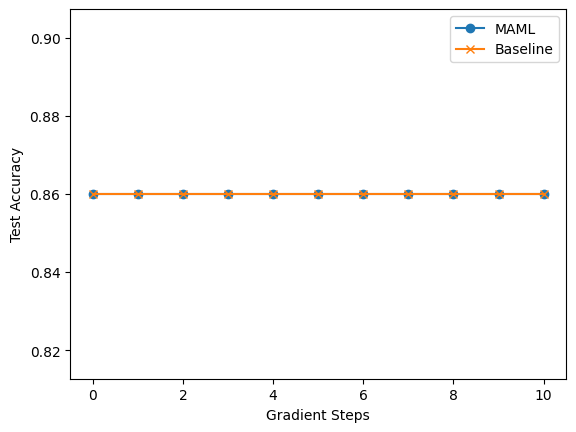

In [24]:
def evaluate_steps(maml_model, baseline_model, test_task, max_steps=10, alpha=0.01):
    x_s, y_s = test_task.sample_data(k=10) # Support
    x_q, y_q = test_task.sample_data(k=100) # Query for testing

    maml_accs = []
    base_accs = []

    # helper to compute accuracy
    def get_acc(model, x, y, params=None):
        with torch.no_grad():
            preds = model(x, params=params)
            preds = (preds > 0.5).float()
            return (preds == y).float().mean().item()

    # Initial accuracy (0 steps)
    maml_accs.append(get_acc(maml_model, x_q, y_q))
    base_accs.append(get_acc(baseline_model, x_q, y_q))

    # Adaptation steps
    maml_params = dict(maml_model.named_parameters())
    base_params = dict(baseline_model.named_parameters())

    for step in range(max_steps):
        # MAML step
        y_p_s = maml_model(x_s, params=maml_params)
        loss = nn.BCELoss()(y_p_s, y_s)
        grads = torch.autograd.grad(loss, maml_params.values(), create_graph=True if step < max_steps -1 else False)
        maml_params = {n: p - alpha * g for (n, p), g in zip(maml_params.items(), grads)}
        maml_accs.append(get_acc(maml_model, x_q, y_q, params=maml_params))

        # Baseline step (fine-tuning)
        # Note: For baseline, we need to adapt it using its own `evaluate_baseline` logic or similar.
        # This current implementation is adapting the _initial_ baseline parameters like MAML.
        # A more accurate comparison might involve `copy.deepcopy` for each step or using `evaluate_baseline`
        # However, for direct comparison with MAML's parameter update, we follow a similar pattern here.
        y_p_b = baseline_model(x_s, params=base_params)
        loss_b = nn.BCELoss()(y_p_b, y_s)
        grads_b = torch.autograd.grad(loss_b, base_params.values(), create_graph=True if step < max_steps -1 else False)
        base_params = {n: p - alpha * g for (n, p), g in zip(base_params.items(), grads_b)}
        base_accs.append(get_acc(baseline_model, x_q, y_q, params=base_params))

    return maml_accs, base_accs

# Instantiate and train the baseline model
baseline_model = CircleModel()
train_baseline(baseline_model)

# Plotting
maml_accs, base_accs = evaluate_steps(maml_model, baseline_model, MovingCircleTask())
plt.plot(range(len(maml_accs)), maml_accs, label='MAML', marker='o')
plt.plot(range(len(base_accs)), base_accs, label='Baseline', marker='x')
plt.xlabel('Gradient Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

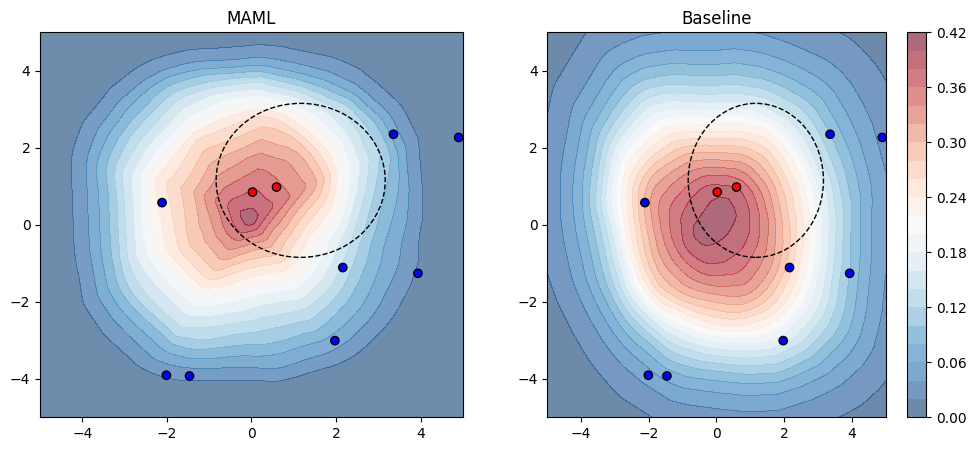

In [27]:
def plot_comparative_heatmaps(maml_model, baseline_model):
    task = MovingCircleTask()
    x_s, y_s = task.sample_data(k=10)

    # One-step adaptation for both
    def adapt_one_step(model, x, y):
        p = dict(model.named_parameters())
        loss = nn.BCELoss()(model(x, params=p), y)
        grads = torch.autograd.grad(loss, p.values())
        return {n: param - 0.01 * g for (n, param), g in zip(p.items(), grads)}

    maml_fast = adapt_one_step(maml_model, x_s, y_s)
    base_fast = adapt_one_step(baseline_model, x_s, y_s)

    # Grid for heatmap
    grid_x, grid_y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_t = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)

    with torch.no_grad():
        maml_preds = maml_model(grid_t, params=maml_fast).reshape(100, 100).numpy()
        base_preds = baseline_model(grid_t, params=base_fast).reshape(100, 100).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Ground Truth Circle
    circle = plt.Circle((task.cx, task.cy), 2.0, color='black', fill=False, linestyle='--')

    for ax, preds, title in zip([ax1, ax2], [maml_preds, base_preds], ["MAML", "Baseline"]):
        c = ax.contourf(grid_x, grid_y, preds, levels=20, cmap='RdBu_r', alpha=0.6)
        ax.scatter(x_s[:,0], x_s[:,1], c=y_s.flatten(), cmap='bwr', edgecolors='k')
        ax.add_patch(plt.Circle((task.cx, task.cy), 2.0, color='black', fill=False, linestyle='--'))
        ax.set_title(title)

    plt.colorbar(c, ax=ax2)
    plt.show()

plot_comparative_heatmaps(maml_model, baseline_model)

**Bonus Question:
"Why does the meta-loss objective in Model-Agnostic Meta-Learning (MAML) exhibit high variance and stochasticity during training compared to standard supervised learning?"**

**Answer:**
The "jumping" or high variance in meta-loss occurs for three primary reasons:

Task Sampling Noise: Unlike standard learning where you sample data from one distribution, MAML samples entire tasks. In one batch, you might get "easy" circles (centered near origin); in the next, "difficult" circles (at the boundaries). The loss spikes simply because the task difficulty changed, not because the model got worse.

The Conflict of Gradients: The meta-update is a "tug-of-war." The model is trying to find a single starting point ($\theta$) that satisfies multiple different tasks. If Task A wants to move left and Task B wants to move right, the meta-loss fluctuates as the model searches for the optimal middle ground.

Second-Order Derivatives: Because MAML calculates the "gradient of a gradient," the optimization landscape is mathematically much more complex and "curvy" than standard regression. Small changes in the initial weights can lead to large changes in the post-adaptation loss.
